# Filtering GPS track

<br/>
<div class="alert alert-block alert-warning" style="padding:1em">
<b>Filtering:</b> this operation altering observation values preserving timestamps and without deleting or creating new observations. Methods are usually "local" methods and working with a neighborhood (e.g. kernel).</div>

In **tracklib**, filtering approaches available are:

* des filtres séquentiels (ou filtres à noyaux), qui travaillent directement dans le domaine spatial ou temporel et avec un noyau local
* des filtres dynamiques (qui nécessitent des informations sur la dynamique du mobile) : Kalman et Markov
* des filtres statistiques (qui étudient par "apprentissage" la distribution des données sur un jeu de données d'exemple. Ici, il y aura Karhunen-Loève (ACP fonctionnelle) qui est au statut de "TO DO"
* des filtres fréquentiels, qui travaillent dans le domaine spectrale pour modifier la trace. Pour l'instant il y a les passe-bas et passe-haut de Fourier et il y aura les ondelette en "TO DO".


## Let's start by defining our environment

This task is only useful for the online notebook

In [1]:
import matplotlib.pyplot as plt
import os
import sys

#-------------------------------------------------------
# Import de tracklib

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tracklib as trk

code running in a no qgis environment
Code running in a no qgis environment


In [2]:
# Import de la librairie tracklib
import tracklib as tkl

# And others
import matplotlib.pyplot as plt

## Filtrage par noyau fenetre glissante de taille 5

In [3]:
# Chargement des données
csvpath = '../../../data/trace0.gps'
        
tkl.ObsTime.setPrintFormat("2D/2M/4Y 2h:2m:2s.3z")
track = tkl.TrackReader.readFromCsv(csvpath) % 10

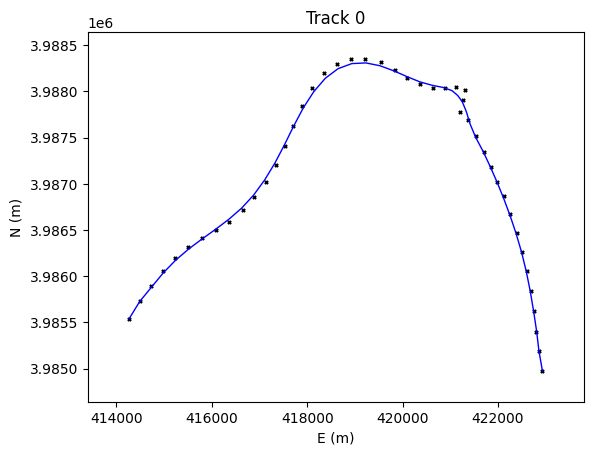

In [4]:
track.plot('kx')

# Filtrage par noyau fenetre glissante de taille 5
track = tkl.filter_seq(track, kernel=5, dim=tkl.FILTER_XY)
track.plot('b-')

plt.show()

## Application à la détection des lacets